# **Stock Market Perdiction**

# Import Library

In [41]:
import yfinance as yf
import pandas as pd
import os

## Import Data

In [42]:
if os.path.exists("stock.csv"):
    stock = pd.read_csv("stock.csv", index_col=0)
else:
    stock = yf.Ticker("^NSEI")
    stock = stock.history(period="max")
    stock.to_csv("stock.csv")

In [43]:
stock.index = pd.to_datetime(stock.index)

In [44]:
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902,0,0.0,0.0
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195,0,0.0,0.0
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098,0,0.0,0.0
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805,0,0.0,0.0
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-07-16 00:00:00+05:30,24615.900391,24661.250000,24587.650391,24613.000000,283200,0.0,0.0
2024-07-18 00:00:00+05:30,24543.800781,24837.750000,24504.449219,24800.849609,350900,0.0,0.0
2024-07-19 00:00:00+05:30,24853.800781,24854.800781,24508.150391,24530.900391,343800,0.0,0.0


<Axes: xlabel='Date'>

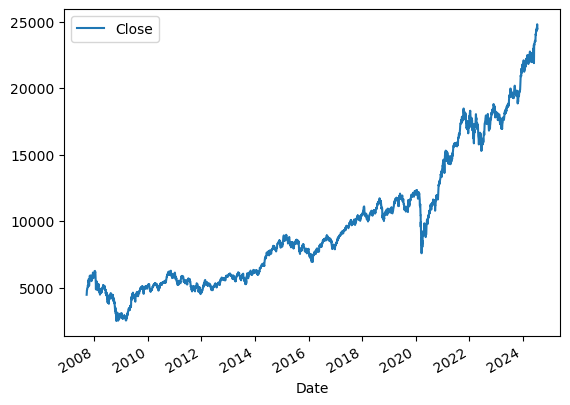

In [45]:
stock.plot.line(y="Close", use_index=True)

In [46]:
del stock["Dividends"]
del stock["Stock Splits"]

In [47]:
stock["Tomorrow"] = stock["Close"].shift(-1)

In [48]:
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)

In [49]:
stock = stock.loc["1990-01-01":].copy()

In [50]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [51]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5921052631578947

<Axes: xlabel='Date'>

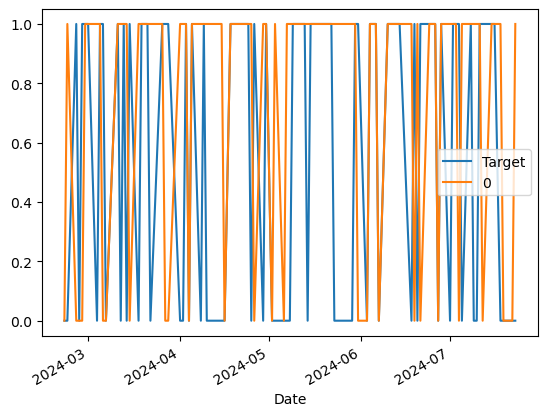

In [52]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [53]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [54]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [55]:
predictions = backtest(stock, model, predictors)

In [56]:
predictions["Predictions"].value_counts()

Predictions
1    872
0    756
Name: count, dtype: int64

In [57]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5458715596330275

In [58]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.550983
0    0.449017
Name: count, dtype: float64

In [59]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = stock.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    stock[ratio_column] = stock["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [60]:
stock = stock.dropna(subset=stock.columns[stock.columns != "Tomorrow"])

In [61]:
stock

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2011-10-13 00:00:00+05:30,5130.799805,5136.950195,5067.649902,5077.850098,0,5132.299805,1,0.997883,1.0,1.014789,3.0,0.992330,23.0,0.911365,111.0,1.042939,510.0
2011-10-14 00:00:00+05:30,5057.350098,5141.399902,5056.600098,5132.299805,0,5118.250000,0,1.005333,1.0,1.015754,3.0,1.004393,24.0,0.921801,111.0,1.053995,510.0
2011-10-17 00:00:00+05:30,5156.200195,5160.200195,5084.500000,5118.250000,0,5037.500000,0,0.998629,1.0,1.007444,2.0,1.003264,23.0,0.919921,111.0,1.051026,509.0
2011-10-18 00:00:00+05:30,5049.450195,5057.500000,5011.049805,5037.500000,0,5139.149902,1,0.992049,0.0,0.989091,2.0,0.989147,23.0,0.906187,110.0,1.034383,508.0
2011-10-19 00:00:00+05:30,5080.450195,5148.049805,5075.299805,5139.149902,0,5091.899902,0,1.009989,1.0,1.007477,2.0,1.010438,24.0,0.925163,111.0,1.055190,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 00:00:00+05:30,24615.900391,24661.250000,24587.650391,24613.000000,283200,24800.849609,1,1.000535,2.0,1.005908,3.0,1.064072,38.0,1.157850,149.0,1.417305,569.0
2024-07-18 00:00:00+05:30,24543.800781,24837.750000,24504.449219,24800.849609,350900,24530.900391,0,1.003802,2.0,1.009653,4.0,1.070147,38.0,1.165493,149.0,1.426951,569.0
2024-07-19 00:00:00+05:30,24853.800781,24854.800781,24508.150391,24530.900391,343800,24509.250000,0,0.994528,1.0,0.996919,4.0,1.056831,37.0,1.151704,148.0,1.410289,568.0


In [62]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [63]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [64]:
predictions = backtest(stock, model, new_predictors)

In [65]:
predictions["Predictions"].value_counts()

Predictions
0.0    567
1.0     61
Name: count, dtype: int64

In [66]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5737704918032787

In [67]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.546178
0    0.453822
Name: count, dtype: float64

In [68]:
predictions

,Target,Predictions
Date,,
2022-01-04 00:00:00+05:30,1,0.0
2022-01-05 00:00:00+05:30,0,0.0
2022-01-06 00:00:00+05:30,1,0.0
2022-01-07 00:00:00+05:30,1,0.0
2022-01-10 00:00:00+05:30,1,1.0
...,...,...
2024-07-16 00:00:00+05:30,1,0.0
2024-07-18 00:00:00+05:30,0,0.0
2024-07-19 00:00:00+05:30,0,0.0
